In [43]:
from IPython.display import display, Math, Latex

import pandas as pd
import numpy as np
import numpy_financial as npf
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime

## Strategy

The strategy is largely composed of two components
1. Algorithmically selecting 25 stocks
2. Generating portfolios composed of the above 25 stocks with different weightings and selecting a specific portfolio based on it's volatility (e.g. the minimum volatility portfolio) 

### 1) Algorithmically selecting 25 stocks
Initial considerations for part 1) included:

  1. Standard Deviation
     - Interconnectedness of the portfolio is largely unknown and when a portfolio is compromised of multiple different stocks, the interconnectedness of the risk is embedded in its intensity
  2. Correlation
     - Selecting based on correlation would involve a lot of intermediate recalculation
     - Individual stocks may have variable volatility
  1. Industry Specific Adjustments
     - This would involve running a randomized algorithm against a set of datasets to generate coefficients for industry specific adjustments
     - Defensive industries comprise of businesses that are relatively stable and immune to economic fluctuations
     - Must be done in combination with another factor

We opted to use only standard deviation as the length of the competition is relatively short, and since the other options (specifically industry specific adjustments) aren't suited for the condensed timeframe. We also decided on picking the maximum number of stocks per the constraints of the project, as this would help us diversify the risk across the portfolio since we have opted for a safe portfolio. The standard deviation shows the average fluctuation in the price of stocks, so the lower the standard deviation, the less volatile the price, and thus the safer the portfolio.

In this part, we read in the tickers, filter and sort them based on their standard deviation. Then we select the first 25 stocks with the lowest standard deviation.

In [44]:
def filterByDenom(ticker):
    # Check if a stock is a "US listed stock"
    return ticker.info['currency'] != 'USD'

def filterByVol(hist):
    # Check the average monthly volume
    return  hist['Volume'].mean() < 200000

def filterByTDays(df_hist):
    df = df_hist.copy()
    # Iterate across time range with months January to October
    for month in range(1, 11):
        # Get numerical month value of each index
        idx = pd.to_datetime(df.index).month
        # Get subset of df_hist of a specific month
        df_month = df.loc[idx == month]
        # Filter by number of entries/trading days for a specific month 
        if (len(df_month) < 20):
            df.drop(df[idx == month].index, inplace=True)
    return df



In [45]:
def getHist(tickers):
    # Set defaults for timeframe
    start_date = '2022-01-01'
    end_date = '2022-11-01' # adjustment for non-inclusive param end

    # Create dataframe to hold historic data from tickers
    df_sv = pd.DataFrame()

    # Get the closing price of each ticker 
    for tick in tickers['Tickers']:
        # Call API for ticker data
        temp = yf.Ticker(tick)

        # Get historical data
        #   Note: the method history() prints out the delisted message
        temp_hist = temp.history(start=start_date, end=end_date, interval='1d')

        # Filter by denom and volume of non-delisted tickers
        if (not temp_hist.empty) and (not (filterByDenom(temp) or filterByVol(temp_hist))):
            # Get Closing Price as a DataFrame
            df_sv[tick] = pd.DataFrame(temp_hist['Close'])

    # Remove indeterminate or faulty values
    df_sv.dropna(axis=1,how='all',inplace = True)
    df_sv.dropna(inplace = True)

    # Filter by number of trading days
    df_sv = filterByTDays(df_sv)
    return df_sv

In [46]:
def sorHistPct(df_pct):
    # Sort arrays by std
    return df_pct.reindex(df_pct.std().sort_values().index, axis=1)

In [47]:
def getReturns(pct, weights):
    # Calculate annuzalized returns
    return (np.sum(pct.mean() * weights)) * 253

def getStd(pct, weights):
    # Calculate annuzalized std
    return np.sqrt(np.transpose(weights) @ (pct.cov() * 253) @ weights)

### 2)  Portfolio Generation
From the 25 stocks we've selected above, we now calulate weightings for those stocks such that we minimize the volatility of the portfolio through the allocation of the portfolio weights.

This is fundamentally an optimization problem, however even with the reduced range of weights of 2-25% instead of 0-100%,
as a computer can only make 10^8 computations per second, it would take far too long to generate the weights with a traditional algorithm.

As a result we opted to use a randomized algorithm. 

The algorithm functions as follows:
1. we generate values using a uniform random number generation method
   - the reason we use an uniform generation method is to keep our portfolios from being skewed towards a specific weighting       
2. set those numbers as weights to our portfolio(adjusting for the constraints of the assignment)

We repeat the above steps for 10^4 different portfolios

Note: 10^5 is our preferred value as it provides a fairly good approximation for our needs, however, the run-time is around 4 minutes, so we've decided to use 10^4 instead


Generating portfolios of 10^n where n>5 doesn't provide much benefits relative to the amount of time it takes to run

In [48]:
def randSimulation(pct):
    # Number of random portolfios to generate
    # Possible consideration is n = 10**5 since it provides a more accurate approximation
        # Note: generation 10**x portfolios where x>5 produces negligible results
        #   and the benefits are largely outweighed by the runtime
    n = 10**4 
    
    # Get the number of tickers
    ticker_count = len(pct.columns)

    # Lists to store portfolio data
    list_return = []
    list_std = []
    list_weight = []

    # Generate n random portfolios
    for p in range(n):
        # Get random values between 0 and 1
        #   Note: we use the uniform generation method as we want the samples to be dispersed evenly 
        weights = np.random.uniform(size= ticker_count)

        # Calculating and establishing lower bound for random portfolio weights
        #   Note: in establishing this lower bound we no longer need to consider the upper bound as it 
        #       would be impossible for any one ticker to have more than 25% allocation with the given lower bound
        low = 0.02
        temp = weights
        temp = (temp/temp.sum()*(1-low*ticker_count))
        weights = temp+low

        # Store randomly generated portfolio data in lists
        list_weight.append(weights)
        list_return.append(getReturns(pct,weights))
        list_std.append(getStd(pct,weights))

    # Convert list to np arrays
    arr_return = np.array(list_return)
    arr_std = np.array(list_std)
    arr_weight = np.array(list_weight)

    return arr_return, arr_std, arr_weight



def graphSimulation(returns, stds, weights):
    # Get information for max sharpe ratio portfolio
    maxs_index = np.argmax(returns/stds)
    maxs_std = stds[maxs_index] 
    maxs_return = returns[maxs_index] 
    ms_weight = weights[maxs_index]
    
    # Get information for min volatility portfolio
    minv_index = np.argmin(stds)
    minv_std = stds[minv_index]
    minv_return = returns[minv_index]
    minv_weight = weights[minv_index]

    print('Min Volatility Portfolio Weights:')
    print(minv_weight)

    print('Min Volatility:')
    print(minv_std)

    # Adjust figure size
    plt.figure(figsize=(20, 10))

    # Plot generated portfolios
    plt.scatter(stds,returns, c=(returns/stds), cmap='winter', s=12, alpha=0.4)
    plt.colorbar(label='Sharpe Ratio', shrink=0.7, cmap='winter')

    # Plot max sharpe ratio portoflio
    plt.scatter(maxs_std,maxs_return,c='plum' , s=120,marker='D', label='Maximum Sharpe Ratio Portfolio')
    # Plot min volatility portfolio
    plt.scatter(minv_std,minv_return,c='palevioletred', s=120, marker='D',label='Minimum Volatility Portfolio')

    # Labels and elements 
    plt.legend()
    plt.title(' Volatility-Returns of Generated Portfolios')
    plt.xlabel('Annualized Portfolio Volatility')
    plt.ylabel('Annualized Portfolio Returns')
    

In [49]:
# Read in csv file containing tickers
tickers = pd.read_csv('Tickers.csv', names = ['Tickers'])
display(tickers)

,Tickers
0,AAPL
1,ABBV
2,ABT
3,ACN
4,AGN
5,AIG
6,AMZN
7,AXP
8,BA
9,BAC


In [50]:
# Get Historic Data for each ticker
hist = getHist(tickers)

Got error from yahoo api for ticker AGN, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}
- AGN: No data found for this date range, symbol may be delisted
Got error from yahoo api for ticker CELG, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}
- CELG: No data found for this date range, symbol may be delisted
- PCLN: No data found for this date range, symbol may be delisted
Got error from yahoo api for ticker RTN, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}
- RTN: No data found for this date range, symbol may be delisted
- TWX: No data found for this date range, symbol may be delisted


In [51]:
# Construct dataframe of percentage change of each stock
hist_pct = hist.pct_change()

# Sort hist_pct based on std
hist_pct = sorHistPct(hist_pct)

# Create new dataframe inplace from the first 25 tickers (25 lowest std)
hist_pct = hist_pct.iloc[:,:25]

In [52]:
# Get data from randomly generated portfolios
gen_return, gen_std, gen_weights = randSimulation(hist_pct)

Min Volatility Portfolio Weights:
[0.04994318 0.05068046 0.05980273 0.06431361 0.06856088 0.05009514
 0.02561251 0.0332895  0.0590496  0.06419211 0.04360279 0.03169505
 0.02567758 0.03729035 0.04424584 0.0259652  0.02056258 0.02404018
 0.02161515 0.02853379 0.02005427 0.02333181 0.04734362 0.02398416
 0.05651793]
Min Volatility:
0.17072709208248926


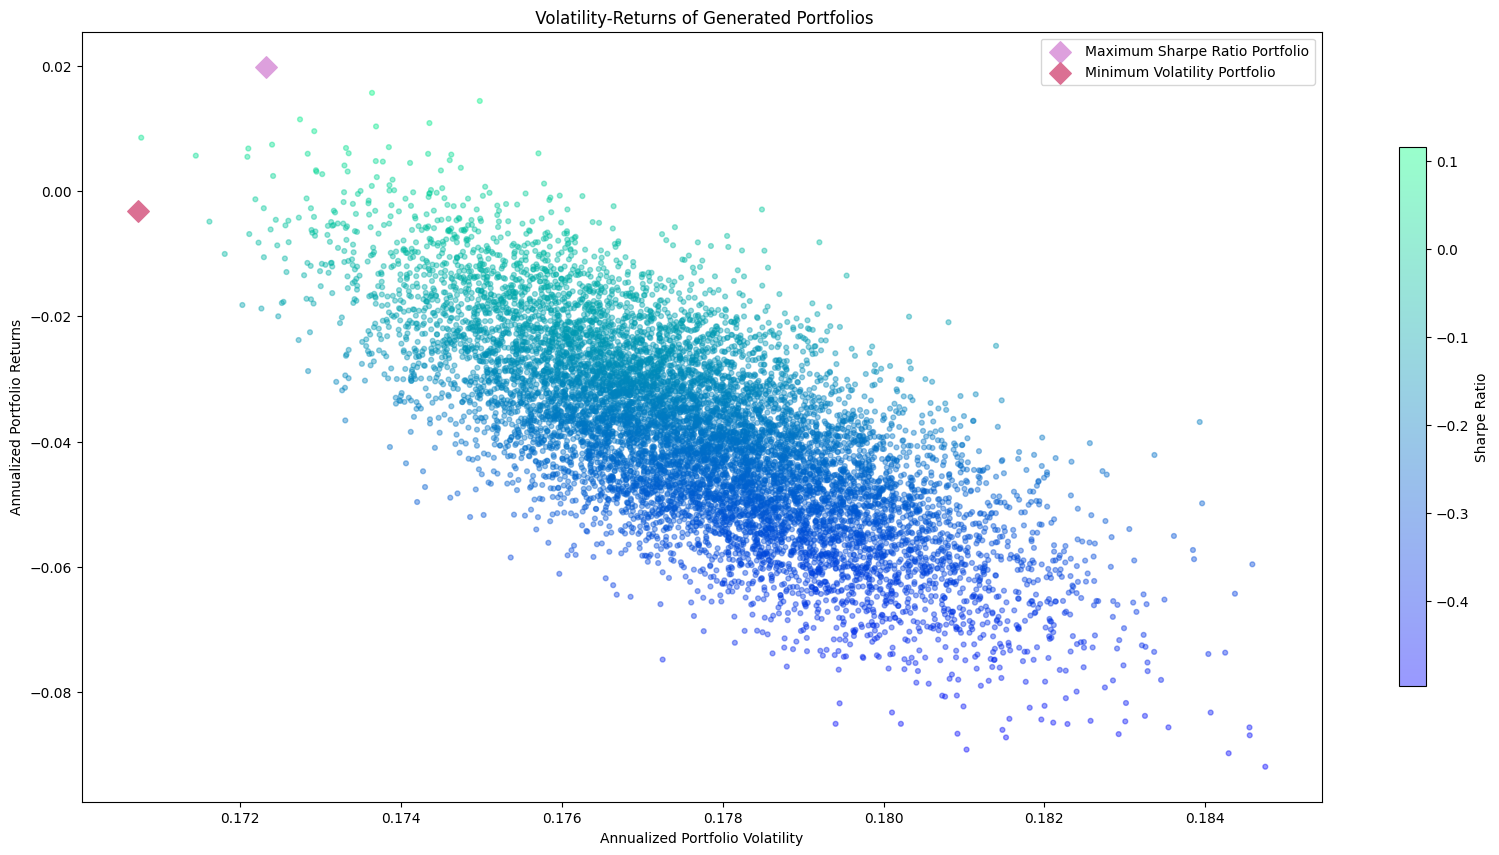

In [53]:
# Graph randomly generated portfolios
graphSimulation(gen_return, gen_std, gen_weights)

## Risk-Return Graph of Generated Portfolios
The graph that is presented below follows the calculations we made in order to get the minimum variance portfolio. The blue diamond indicator represents our minimum variance portfolio that we will be using. It is a collection of 25 different stocks that we have combined after sorting the standard deviation of the stocks that we were given (after filtering out the non-US based stocks), as we have opted for the safe portfolio, hence utilizing the lowest standard deviation stocks. After doing that, the random generator code that we created ran 10^4 calculations in order to locate our minimum variance portfolio, hence from there we are then able to get an approximation of our desired weightings in order to get out optimal portfolio wich minimizes volatility and is considered to be safe.

We have included the maximum Sharpe ratio since this is a widely used method in order to measure risk-adjusted relative returns. It compares a fund's historical or projected returns relative to an investment benchmark with the historical or expected variability of such returns. We decided to represent the difference between the Sharpe ratio and the minimum variance portfolio to show the difference between them. We decided not to use Sharpe ratio as there could be higher risk associated towards those weightings of stocks as it depends on the returns of the portfolio in order to offset the risk. Therefore the portfolio weightings based off the maximum Sharpe ratio as seen below represented by the red diamond could be associated with higher risk even though there’s a higher return, which is not the optimal weightings to use since we have opted for a safe portfolio.

It should also be noted that this method of analyzing various possible portfolios of the given stocks, draws from the Markowitz model, which is foundational to Modern portfolio theory.



In [54]:
# Stores the tickers from hist_oct in a list
tickers = hist_pct.columns
# Get the position of the miimum standard deviation
minv_index = np.argmin(gen_std)
# Get the min weights
minv_weight = gen_weights[minv_index]

# Create Portfolio Final
Portfolio_Final = pd.DataFrame()
# Portfolio_Final = pd.DataFrame(columns=['Tickers', 'Price', 'Shares', 'Value', 'Weight'])
for i in range(25):
        # Set time range to get ticker data
        Start_Date ='2022-11-25'
        End_date = '2022-11-26'# adjustment for non-inclusive end
        # Initial investment
        Investment = 500000
        Stock_a = yf.Ticker(tickers[i])
        Stock_a_hist = Stock_a.history(start=Start_Date)
        Closing_Price = Stock_a_hist['Close']
        Shares = ((minv_weight[i] * Investment) / Closing_Price)
        Value = Shares * Closing_Price
        Portfolio_Final_2 = pd.DataFrame({'Tickers': tickers[i], 'Price': Closing_Price, 'Shares': Shares,
                                       'Value': Value, 'Weight': minv_weight[i]})
        Portfolio_Final = pd.concat([Portfolio_Final, Portfolio_Final_2], ignore_index=True)

# Reindex portfolio from 1
Portfolio_Final.index = np.arange(1, len(Portfolio_Final) + 1)
display(Portfolio_Final)
print('Total:')
print('$'+ str(Portfolio_Final['Value'].sum())+' USD')
print('Total weight:')
print(str(Portfolio_Final['Weight'].sum()) + '%') 

,Tickers,Price,Shares,Value,Weight
1,KO,62.689999,398.334533,24971.591317,0.049943
2,MRK,107.500000,235.723056,25340.228498,0.050680
3,BMY,79.239998,377.351927,29901.365880,0.059803
4,PEP,184.110001,174.660817,32156.803084,0.064314
5,CL,76.769997,446.534339,34280.439709,0.068561
6,PG,146.720001,170.716810,25047.570542,0.050095
7,SO,66.910004,191.395245,12806.256562,0.025613
8,UNH,537.619995,30.960064,16644.749251,0.033289
9,PM,98.250000,300.506848,29524.797823,0.059050
10,ABBV,159.619995,201.077917,32096.056120,0.064192


Total:
$500000.0 USD
Total weight:
1.0%


In [55]:
# Create Stocks_Final
Stocks_Final = pd.DataFrame({'Tickers': Portfolio_Final['Tickers'],'Shares': Portfolio_Final['Shares']})
Stocks_Final

,Tickers,Shares
1,KO,398.334533
2,MRK,235.723056
3,BMY,377.351927
4,PEP,174.660817
5,CL,446.534339
6,PG,170.716810
7,SO,191.395245
8,UNH,30.960064
9,PM,300.506848
10,ABBV,201.077917


In [56]:
# Create csv file from Stock_Final
Stocks_Final.to_csv("Stocks_Group_09.csv")